<a href="https://colab.research.google.com/github/cehkop/Deep_learning_school_MIPT/blob/main/homewowk/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [206]:
import numpy as np
from matplotlib import pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
import torch.utils.data as data_utils
## Progress bar
from tqdm.notebook import tqdm
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


try:
    from livelossplot import PlotLosses
except:
    !pip install livelossplot
    from livelossplot import PlotLosses

%matplotlib inline

In [207]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img:resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [208]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

dataset_orig, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [209]:
from sklearn.model_selection import train_test_split

train_photos, val_photos, train_attrs, val_attrs = train_test_split(dataset_orig, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=16)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=16)

In [210]:
# # Transformations applied on each image => only make them a tensor
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Resize((64,64), antialias=True),
#                                 transforms.Normalize((0.5,),(0.5,)),
#                                 ])

# dataset = datasets.ImageFolder(root=r'/content/lfw-deepfunneled', 
#                                transform=transform)

# # Loading the training dataset. We need to split it into a training and validation part
# train_set, val_set = data.random_split(dataset, 
#                                        [round(len(dataset)*.85), 
#                                         round(len(dataset)*.15)
#                                         ]
#                                        )

# train_loader = data.DataLoader(train_set, 
#                                batch_size=8,
#                                shuffle=True, 
#                                drop_last=True, 
#                                pin_memory=True, 
#                                num_workers=2)

# val_loader = data.DataLoader(val_set, 
#                              batch_size=8, 
#                              shuffle=False, 
#                              drop_last=True, 
#                              num_workers=2)

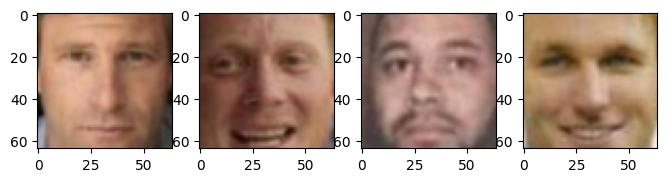

In [211]:
plt.figure(figsize=(8, 20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # img = np.transpose(next(iter(train_loader))[0][i], (1, 2, 0))
    img = next(iter(train_loader))[i]
    plt.imshow(img)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

## Прикольный материал, которым пользовался
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [212]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 64x64=> 32x32
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(2*c_hid, 2*2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*2*c_hid, 2*2*c_hid, kernel_size=3, padding=1, stride=1), # 16x16 => 8x8
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*2*8*8*c_hid, latent_dim),
        )
    
    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. 
                For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. 
                Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.c_hid = base_channel_size

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*2*8*8*self.c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.Conv2d(2*2*self.c_hid, 2*2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*2*self.c_hid, 2*self.c_hid, kernel_size=3, output_padding=1, 
                               padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(2*self.c_hid, 2*self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*self.c_hid, self.c_hid, kernel_size=3, 
                               output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(self.c_hid, self.c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(self.c_hid, self.c_hid, kernel_size=3, 
                               output_padding=1, padding=1, stride=2), # 32x32 => 64x64
            act_fn(),
            nn.Conv2d(self.c_hid, num_input_channels, kernel_size=3, padding=1),
            nn.Tanh() # The input images is scaled between -1 and 1, 
                        # hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        # print(x.shape)
        x = x.reshape(-1, 2*2*self.c_hid, 8, 8)
        # print(x.shape)
        x = self.net(x)
        # print(x.shape)
        return x


class Autoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 ):
        self.latent_dim = latent_dim
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        # print(x.shape)
        l = self.encoder(x)
        # print(l.shape)
        x_hat = self.decoder(l)
        return l, x_hat

    def get_latent_vector(self, x):
        z = self.encoder(x)
        return z

    def sample(self, z):
        generated = self.decoder(z)
        # generated = generated.view(-1, 3, 64, 64)
        return generated



In [213]:
model = Autoencoder(base_channel_size = 64, 
                    latent_dim = 256)
# define loss, optimizer and learning rate scheduler
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=5,
                                            gamma=0.1)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

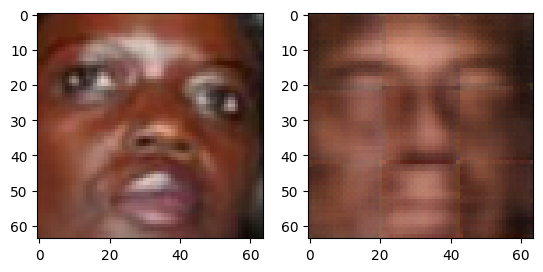

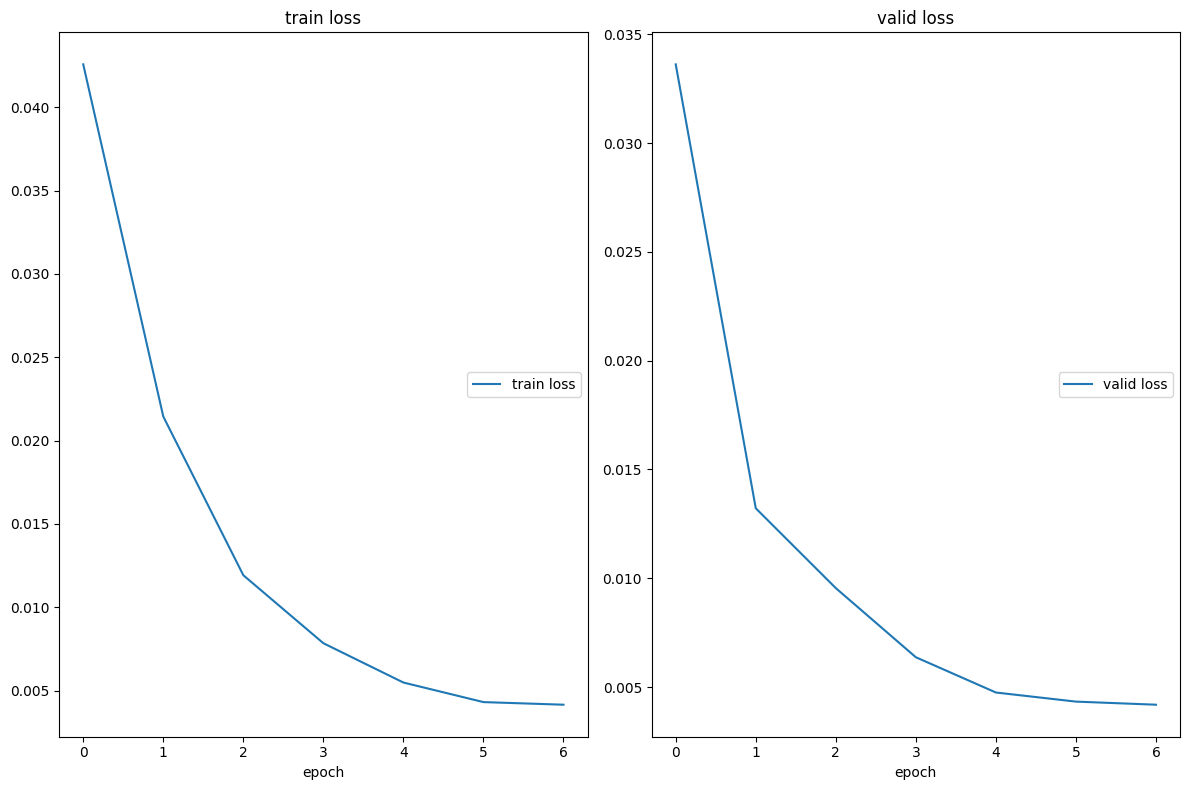

train loss
	train loss       	 (min:    0.004, max:    0.043, cur:    0.004)
valid loss
	valid loss       	 (min:    0.004, max:    0.034, cur:    0.004)


  0%|          | 0/740 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 10
train_losses = []
val_losses = []
model.to(device)

liveloss = PlotLosses()
logs={}

for epoch in tqdm(range(n_epochs), leave=False):
    model.train()
    train_losses_per_epoch = []
    for batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        batch = batch.view(-1, 3, 64, 64).float().to(device)
        lat, reconstruction = model(batch)
        loss = criterion(reconstruction, batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.view(-1, 3, 64, 64).float().to(device)
            lat, reconstruction = model(batch)
            loss = criterion(reconstruction, batch)
            val_losses_per_epoch.append(loss.item())
        
        plt.subplot(1, 2, 1)
        plt.imshow(batch[0].cpu().view(64, 64, -1))
        plt.subplot(1, 2, 2)
        plt.imshow(reconstruction[0].cpu().view(64, 64, -1))

    scheduler.step()
    val_losses.append(np.mean(val_losses_per_epoch))

    logs['train loss'] = np.mean(train_losses_per_epoch)
    logs['valid loss'] = np.mean(val_losses_per_epoch)
    liveloss.update(logs)
    liveloss.send()


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.view(-1, 3, 64, 64).float().to(device)
        lat, reconstruction = model(batch)
        result = reconstruction.cpu().detach()
        ground_truth = batch
        break

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt.cpu().view(64, 64, -1))
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res.cpu().view(64, 64, -1))

Not bad, right? 
(ну такое себе))

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
model.eval()
lat_mean = []
lat_std = []
with torch.no_grad():
    for batch in train_loader:
        batch = batch.view(-1, 3, 64, 64).float().to(device)
        lat = model.get_latent_vector(batch.to(device))
        lat_mean.append(np.mean(lat.tolist()))
        lat_std.append(np.std(lat.tolist()))

mu = np.mean(lat_mean)
std = np.std(lat_std)
print(f'mu = {mu:.3f}, std = {std:.3f}')

In [ ]:
# сгенерируем 10 рандомных векторов размера latent_space
z = np.array([np.random.normal(mu, std, 256) for i in range(2)])
output = model.sample(torch.FloatTensor(z).to(device))

plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach()
  plt.imshow(generated.view(64, 64, -1))
plt.show()

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [13]:
# get img with smile
index_smile = attrs.index[(attrs['Smiling']>2)].tolist()
no_index_smile = attrs.index[(attrs['Smiling']<-2)].tolist()

smiling_dataset = np.take(dataset_orig, index_smile, axis=0)
no_smiling_dataset = np.take(dataset_orig, no_index_smile, axis=0)

smile_loader = torch.utils.data.DataLoader(smiling_dataset, batch_size=8)
no_smile_loader = torch.utils.data.DataLoader(no_smiling_dataset, batch_size=8)

In [14]:
model.eval()
latent_set_no_smile, latent_set_smile = [], []
with torch.no_grad():
    for batch in smile_loader:
        batch = batch[0].to(torch.float32).view(-1, 3, 64, 64)
        lat = model.get_latent_vector(batch.to(device))
        latent_set_smile.append(lat.tolist())


with torch.no_grad():
    for batch in no_smile_loader:
        batch = batch[0].to(torch.float32).view(-1, 3, 64, 64)
        lat = model.get_latent_vector(batch.to(device))
        latent_set_no_smile.append(lat.tolist())

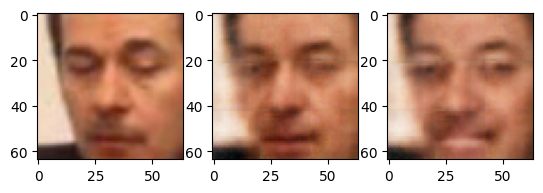

In [15]:
smile = np.mean(latent_set_smile, axis = 0) - np.mean(latent_set_no_smile, axis = 0)

plt.subplot(1, 3, 1)
orig = next(iter(no_smile_loader))[0]
orig = orig.float()
plt.imshow(orig)

plt.subplot(1, 3, 2)
orig = orig.view(-1, 3, 64, 64)
lat, rec = model(orig.to(device))
# plt.imshow(rec[0].view(64, 64, -1).cpu().detach().numpy())
img = model.sample(torch.FloatTensor(lat.tolist()).to(device))
plt.imshow(img[0].view(64, 64, -1).cpu().detach().numpy())

plt.subplot(1, 3, 3)
img_smile = model.sample(torch.FloatTensor(lat.tolist()+smile).to(device))
plt.imshow(img_smile[0].view(64, 64, -1).cpu().detach().numpy())

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [16]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 385010198.03it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108934976.46it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 98910075.61it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 15338589.99it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [88]:
class VAE(nn.Module):
    def __init__(self, inp_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.inp_dim = inp_dim
        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=inp_dim, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=latent_dim*2)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=inp_dim)
        )


    def encode(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        return mu, log_var
    
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z):
        rec = self.decoder(z)
        rec = rec.view(-1, 28, 28, 1)
        return rec

    def forward(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
 
        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [18]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

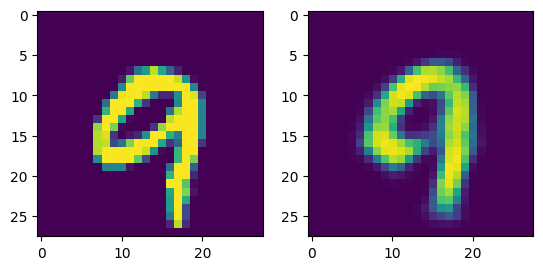

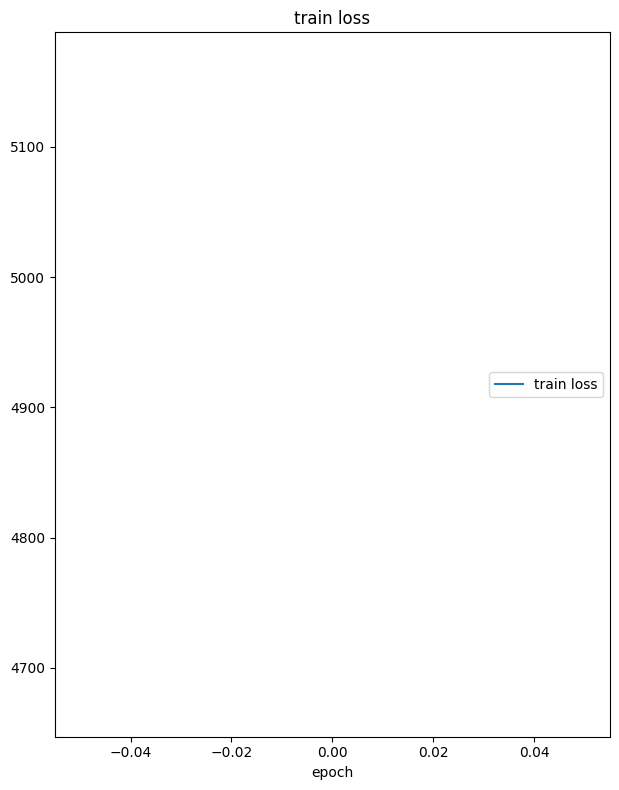

train loss
	train loss       	 (min: 4917.478, max: 4917.478, cur: 4917.478)


In [89]:
model = VAE(inp_dim = 28*28, latent_dim = 16)
# define loss, optimizer and learning rate scheduler
criterion = loss_vae
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=5,
                                            gamma=0.1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 10
train_losses = []
val_losses = []
model.to(device)

liveloss = PlotLosses()
logs={}

for epoch in tqdm(range(n_epochs), leave=False):
    model.train()
    train_losses_per_epoch = []
    for batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()

        reconstruction, mu, logsigma = model(batch[0].to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    plt.subplot(1, 2, 1)
    plt.imshow(batch[0][0].cpu().view(28, 28, -1))
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction[0][0].detach().cpu().view(28, 28, -1))

    scheduler.step()

    logs['train loss'] = np.mean(train_losses_per_epoch)
    liveloss.update(logs)
    liveloss.send()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

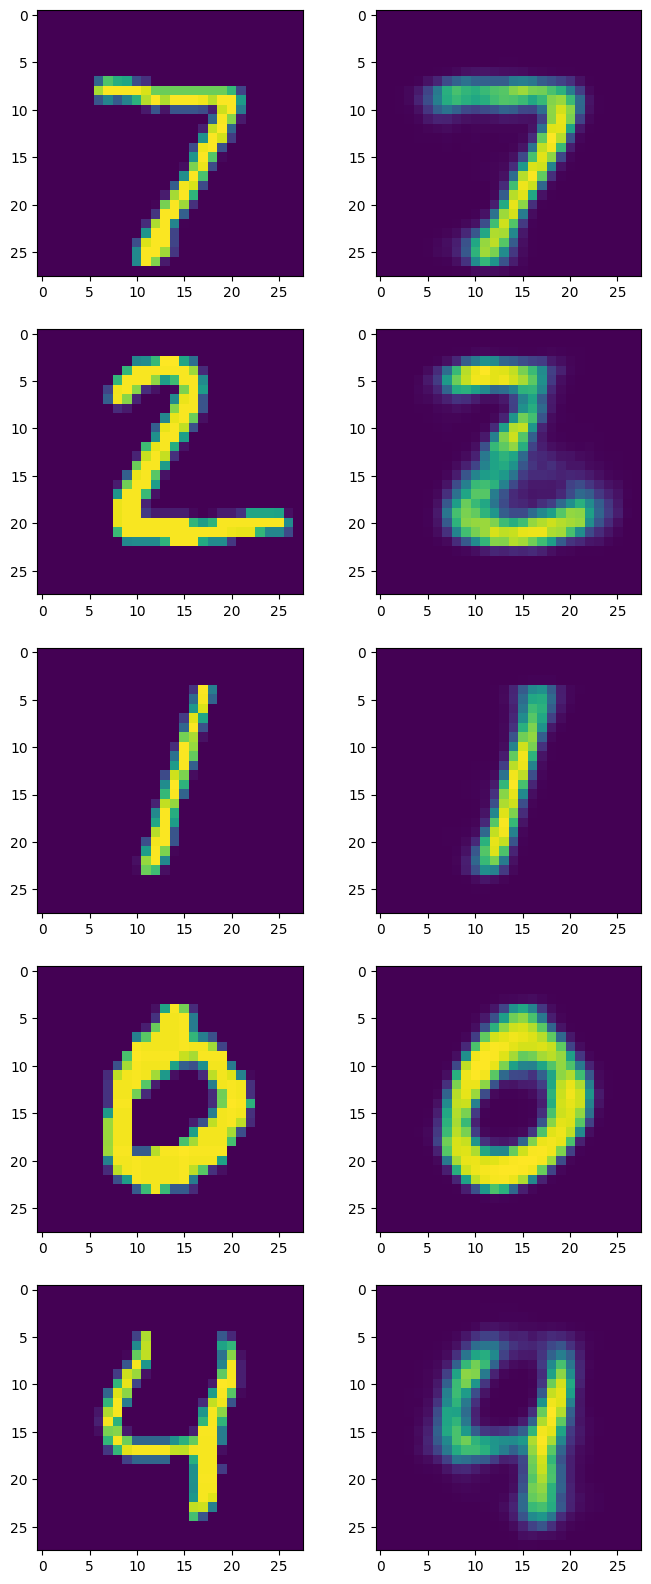

In [20]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
x = 5

model.eval()
with torch.no_grad():
    for batch in test_loader:
        reconstruction, mu, logsigma = model(batch[0].to(device))
        result = reconstruction.cpu().detach().view(-1, 28, 28, 1)
        ground_truth = batch[0]
        break

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:x], result[:x])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt.view(28, 28, 1))
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res.view(28, 28, 1))

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

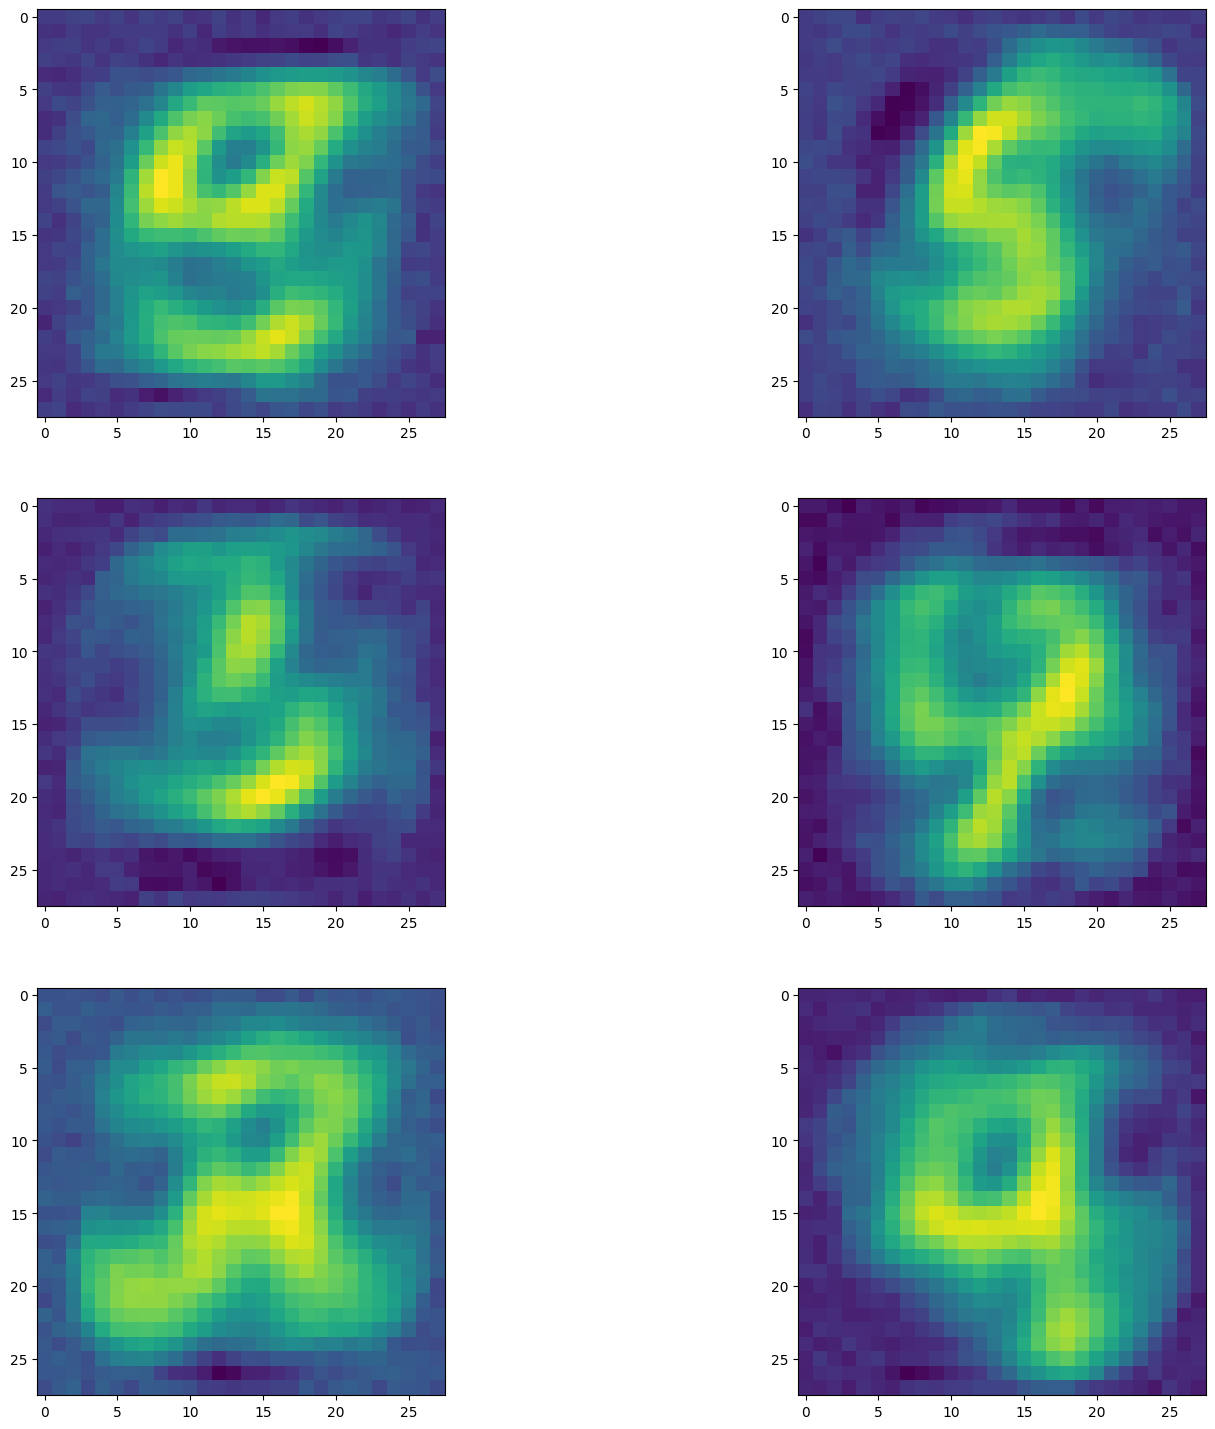

In [22]:
model.eval()
lat_mean, lat_std = [], []
with torch.no_grad():
    for batch in test_loader:
        reconstruction, mu, log_var = model(batch[0].to(device))
        lat_mean.append(np.mean(mu.cpu().squeeze().tolist()))
        lat_std.append(np.std(log_var.cpu().squeeze().tolist()))
        # break

mu = np.mean(lat_mean)
log_var = np.std(lat_std)
std = np.exp(0.5 * log_var)

# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(mu, std, 16) for i in range(6)])
# print(np.shape(z))
input = torch.FloatTensor(z).to(device)

output = model.decode(input)

plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach()
  plt.imshow(generated.view(28, 28, -1))
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [125]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns 

latent = []

# get latent
model.eval()
latent_set_no_smile, latent_set_smile = [], []
with torch.no_grad():
    for batch in test_loader:
        mu, log_var = model.encode(batch[0].to(torch.float32).to(device))
        latent.append(([mu.cpu(), log_var.cpu()], batch[1]))

# extract list to 2-dim
X, Y = [], []
for batchX, batchY in latent:
    x1 = batchX[0]
    x2 = batchX[1]
    x = torch.cat([x1,x2], dim = 1)
    for i in x:
        X.append(i.tolist())
    
    for i in batchY:
        Y.append(i.tolist())

X = np.array(X[0:2000])
Y = np.array(Y[0:2000])

print(f'first, X.shape = {X.shape}')
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
print(f'after t-SNE, X.shape = {tsne_result.shape}')

torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([32, 16])
torch.Size([3

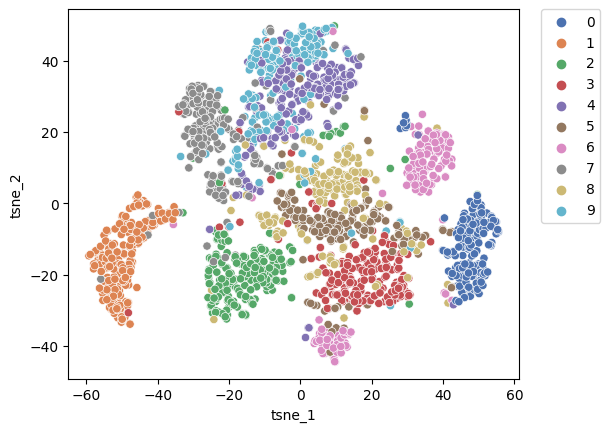

In [123]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 
                               'tsne_2': tsne_result[:,1], 
                               'label': Y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', 
                data=tsne_result_df, ax=ax, palette="deep")
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [126]:
class CVAE(nn.Module):
    def __init__(self, inp_dim, latent_dim, classes_num_all):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inp_dim = inp_dim
        self.flatten = nn.Flatten()
        self.classes_num_all = classes_num_all
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=inp_dim+self.classes_num_all, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=latent_dim*2)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim+self.classes_num_all, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=inp_dim)
        )


    def encode(self, x, class_num):
        class_hot = F.one_hot(class_num, num_classes=10)
        class_hot = self.flatten(class_hot)
        x = self.flatten(x).float()
        x = torch.cat([x, class_hot], dim=1)
        x = self.encoder(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # z = self.gaussian_sampler(mu, log_var)
        return mu, log_var, class_num
    
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z, class_num):
        class_hot = F.one_hot(class_num, num_classes=10)
        class_hot = self.flatten(class_hot)
        z = torch.cat([z, class_hot], dim=1)
        rec = self.decoder(z)
        rec = rec.view(-1, 28, 28, 1)
        return rec

    def forward(self, x, class_num):
        class_hot = F.one_hot(class_num, num_classes=10)
        class_hot = self.flatten(class_hot)
        x = self.flatten(x).float()
        x = torch.cat([x, class_hot], dim=1)
        x = self.encoder(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        z = torch.cat([z, class_hot], dim=1)
 
        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

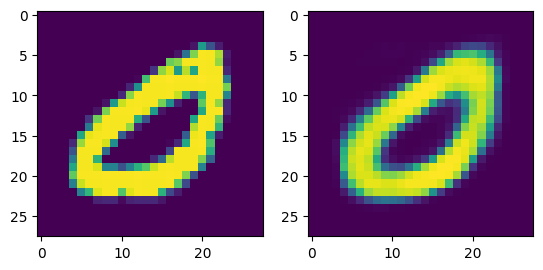

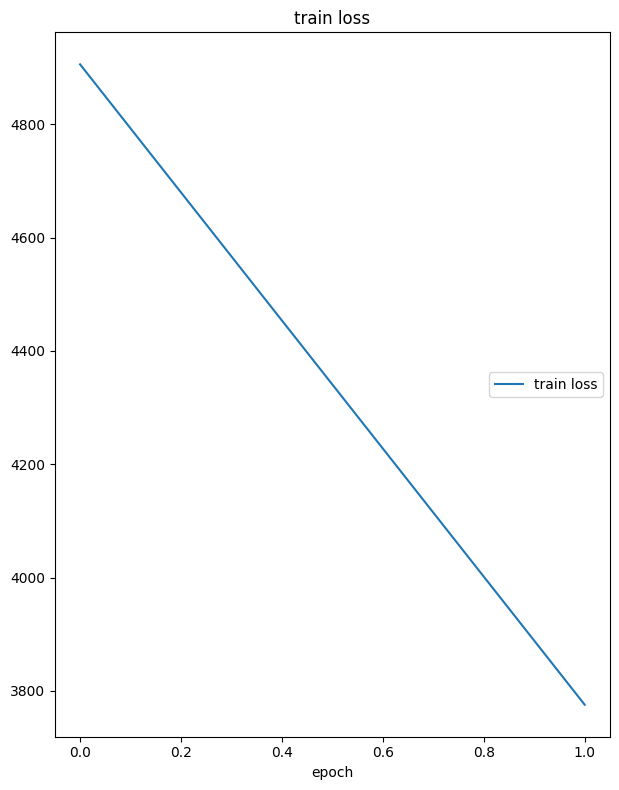

train loss
	train loss       	 (min: 3775.688, max: 4905.594, cur: 3775.688)


In [127]:
model = CVAE(inp_dim = 28*28, latent_dim = 16, classes_num_all = 10)
# define loss, optimizer and learning rate scheduler
criterion = loss_vae
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=5,
                                            gamma=0.1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 10
train_losses = []
val_losses = []
model.to(device)

liveloss = PlotLosses()
logs={}

for epoch in tqdm(range(n_epochs), leave=False):
    model.train()
    train_losses_per_epoch = []
    for batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()

        reconstruction, mu, logsigma = model(batch[0].to(device), batch[1].to(device))
        print()
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch[0].to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    plt.subplot(1, 2, 1)
    plt.imshow(batch[0][0].cpu().view(28, 28, -1))
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction[0][0].detach().cpu().view(28, 28, -1))

    scheduler.step()

    logs['train loss'] = np.mean(train_losses_per_epoch)
    liveloss.update(logs)
    liveloss.send()
     

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
z = np.array([np.random.normal(0, 0.3, 16) for i in range(8)])
# print(np.shape(z))
input = torch.FloatTensor(z).to(device)

output = model.decode(input, 
                      torch.LongTensor([5, 5, 5, 5, 
                                        7, 7, 7, 7]).to(device))

plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach()
  plt.imshow(generated.view(28, 28, -1))
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [131]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns 

latent = []

# get latent
model.eval()
latent_set_no_smile, latent_set_smile = [], []
with torch.no_grad():
    for batch in test_loader:
        batch0 = batch[0].to(torch.float32).to(device)
        batch1 = batch[1].to(device)
        mu, log_var, class_num = model.encode(batch0, batch1)
        latent.append(([mu.cpu(), log_var.cpu()], batch1.cpu()))

# extract list to 2-dim
X, Y = [], []
for batchX, batchY in latent:
    x1 = batchX[0]
    x2 = batchX[1]
    x = torch.cat([x1,x2], dim = 1)
    for i in x:
        X.append(i.tolist())
    
    for i in batchY:
        Y.append(i.tolist())

X = np.array(X[0:2000])
Y = np.array(Y[0:2000])

print(f'first, X.shape = {X.shape}')
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
print(f'after t-SNE, X.shape = {tsne_result.shape}')

first, X.shape = (2000, 32)
after t-SNE, X.shape = (2000, 2)


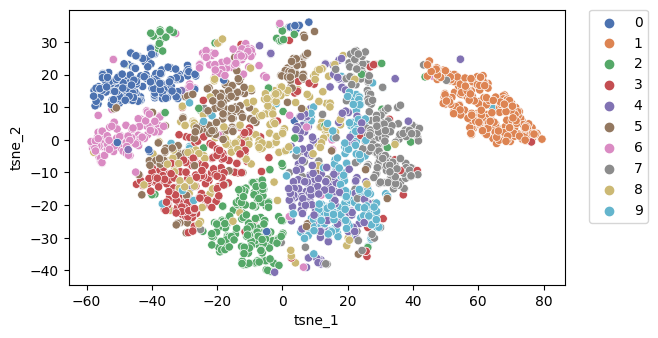

In [132]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 
                               'tsne_2': tsne_result[:,1], 
                               'label': Y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', 
                data=tsne_result_df, ax=ax, palette="deep")
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>